In [1]:
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, ADASYN

import os
import re

In [3]:
## Get metadata for each subject

with open("cm_table.html", "r") as f:
    table = f.read()

soup = BeautifulSoup(table, "html.parser")

rows = soup.find_all(class_="powerTable")[1].tbody.find_all("tr")[3:523]

cols = defaultdict(list)
for row in rows:
    text_list = list(row.stripped_strings)
    if len(text_list) == 13:
        text_list.insert(7, 'na') # insert so list is standard size when that column was empty on the webpage
    cols["study"].append(text_list[2])
    cols["id"].append(text_list[3].replace("_", ""))
    cols["age"].append(float(text_list[8]))
    cols["gender"].append(text_list[10])
    cols["label"].append(text_list[11])

metadata = pd.DataFrame(cols)

In [4]:
metadata

,study,id,age,gender,label
0,ADHD200_CC200,KKI2371032,10.73,Female,Typically Developing
1,ADHD200_CC200,KKI2026113,12.99,Female,ADHD-Combined
2,ADHD200_CC200,KKI3434578,8.12,Female,Typically Developing
3,ADHD200_CC200,KKI8628223,10.81,Female,Typically Developing
4,ADHD200_CC200,KKI1623716,12.65,Female,ADHD-Combined
...,...,...,...,...,...
515,ADHD200_CC200,Pittsburgh0016081,18.81,Male,Typically Developing
516,ADHD200_CC200,Pittsburgh0016032,13.65,Female,Typically Developing
517,ADHD200_CC200,Pittsburgh0016057,16.74,Female,Typically Developing
518,ADHD200_CC200,Pittsburgh0016035,13.94,Male,Typically Developing


## Load the connectivity matrices

In [5]:
def get_conn_matrices():
    file_names = os.listdir("data/ADHD200_CC200")

    cm_file_re = r"^\S+connectivity_matrix_file\.txt$"

    conn_matrices = OrderedDict()
    for file_name in file_names:
        if re.match(cm_file_re, file_name):
            id_ = "".join(file_name.split("_")[:-3])
        
            cm = np.empty((190,190))
            with open("data/ADHD200_CC200/{}".format(file_name)) as f:
                for idx, row in enumerate(f):
                    row = row.strip().split(" ")
                    row = list(map(np.float, row))
                    cm[idx, :] = row
        
            conn_matrices[id_] = cm
    return conn_matrices

In [6]:
def get_regions():
    """
    Gets the names of the regions (in order of appearance in connectivity matrix). 
    All files have the same order of regions, so we only to need to get this once.
    Some region names are repeated because there are multiple points within that region,
        so numbers are appended to the region names to distinguish them.
    
    returns a list of strings
    """
    regions_path = "data/ADHD200_CC200/KKI_1018959_region_names_full_file.txt"
    regions = []
    with open(regions_path, "r") as f:
        regions = [region.strip().replace(" ", "_") for region in f]
    names = defaultdict(int)
    distinct_region_names = []
    for region in regions:
        distinct_region_names.append(region+"_"+str(names[region]))
        names[region] += 1
    return distinct_region_names

In [7]:
region_names = get_regions()

conn_matrices = get_conn_matrices()

## data prep

In [8]:
def flatten_conn_matrices(conn_matrices_dict, region_names):
    """
    Flatten a cm dictionary (mapping subjects to connectivity matrices), such that each unique value in the
        connectivity matrix is a column feature in a row.
    Returns: 1) a numpy array where each row represents a subject with each column a feature;
             2) a list of the subject ids in the order they appear in the feature array;
             3) a list of the feature names in the order they appear in the feature array.
    The subjects list holds the row labels, feature_names list holds column labels.
    """
    subjects = list(conn_matrices_dict.keys())
    num_rows = len(subjects)
    features = np.empty((num_rows, 17955))
    
    # adjacency matrices have duplicate values, only need values from half of the matrix (and don't need diagonal)
    # np.tril_indices() returns indices of unique values
    row_idxs, col_idxs = np.tril_indices(190, k=-1)
    for idx, subject in enumerate(subjects):
        cm = conn_matrices_dict[subject]
        row = np.array([cm[row_idx, col_idx] for row_idx, col_idx in zip(row_idxs, col_idxs)])
        features[idx, :] = row
    
    feature_names = [region_names[row_idx]+"_to_"+region_names[col_idx] 
                     for row_idx, col_idx in zip(row_idxs, col_idxs)]
    
    return features, subjects, feature_names

In [9]:
features, subjects, feature_names = flatten_conn_matrices(conn_matrices, region_names)

In [10]:
# free up some memory
del conn_matrices

In [11]:
def sort_metadata(metadata, subjects):
    """
    Sorts a metadata dataframe so that the order is the same as the order of subjects in the subjects list.
    :arg metadata: dataframe with ADHD200 metadata
    :arg subjects: a list of subjects of specific order
    """
    metadata_ids = metadata["id"].values
    subjects_order_in_metadata = [np.where(metadata_ids==subject)[0][0] for subject in subjects]
    metadata_subject_sort = metadata.iloc[subjects_order_in_metadata, :]
    return metadata_subject_sort

In [12]:
# sort the metadata so that the order is the same as in the feature matrix
metadata_sorted = sort_metadata(metadata, subjects)
adhd = [0 if label == "Typically Developing" else 1 for label in metadata_sorted["label"]]
metadata_sorted = metadata_sorted.assign(adhd=adhd)

In [13]:
def most_correlated_features(features, metadata, feature_names, p_val=.01):
    """
    returns a DataFrame with a subset of the features which have a correlation p value less than the specified cutoff
    :arg features: numpy feature matrix, sorted in the same order as the metadata.
    :arg target: DataFrame with target and ids, sorted in the same order as the feature matrix.
    :arg feature_names: the names of the features in the feature matrix, same order.
    :arg p_val: the maximum p value for a feature to be included.
    """
    # get the p values for correlations. lower is better!
    target=metadata["adhd"] 
    correlation_p_vals = np.array([pearsonr(features[:,col], target)[1] for col in range(features.shape[1])])
    # get the order of columns which are most correlated with having adhd
    corr_p_vals_argsort = correlation_p_vals.argsort()
    # the number of features with correlation p values less than the cutoff
    num_features = np.count_nonzero(correlation_p_vals < p_val)
    # get the indices of features of features with p vals less than the cutoff
    most_correlated = corr_p_vals_argsort[:num_features]
    
    features_most_correlated = features[:, most_correlated]
    feature_names_most_correlated = [feature_names[idx] for idx in most_correlated]
    
    # make features dataframe with the smaller features
    X = pd.DataFrame(features_most_correlated, columns=feature_names_most_correlated)
    X = X.assign(adhd=target.values)
    X = X.assign(id=metadata["id"].values)
    X = X.assign(gender=metadata["gender"].values)
    X = X.assign(gender=pd.get_dummies(X["gender"], drop_first=True)["Male"])
    X = X.assign(age=metadata["age"].values)
    cols = list(X.columns)
    col_order = [cols[-3]] + [cols[-4]] + [cols[-1]] + [cols[-2]] + cols[:-4]
    X = X[col_order]
    
    return X

In [14]:
def subset_train_test(p_val, features=features, metadata_sorted=metadata_sorted, 
           feature_names=feature_names, oversample=True, scale=False):
    
    X = most_correlated_features(features, metadata_sorted, feature_names, p_val=p_val)
    
    print(X.shape[1], "features remaining")
    
    y = X["adhd"]
    X = X.drop(columns=["adhd", "id"])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)
    
    # standard scale the data
    if scale:
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    if oversample:
        X_train, y_train = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)
    
    return (X_train, X_test, y_train, y_test)

## Test different correlation p value cutoffs
Using a lower p value cutoff will get a smaller subset of the features.

In [15]:
def train_score(p_val, model, oversample=True):
    X_train, X_test, y_train, y_test = subset_train_test(p_val, oversample=True)
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    conf_mat = confusion_matrix(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    
    print("p cutoff:", p)
    print("train accuracy: {:.3f}".format(train_acc))
    print("test accuracy: {:.3f}\n".format(test_acc))
    print("ROC AUC: {:.3f}".format(roc_auc))
    print("precision score: {:.3f}".format(precision))
    print("recall score: {:.3f}".format(recall))
    print(conf_mat)
    print("-----------------------------")
    
    return model, X_train.columns

In [16]:
p_vals = [.01, .005, .001, .0005, .0001, .00005, .00001, .000005]
for p in p_vals:
    train_score(p, GaussianNB())

570 features remaining
p cutoff: 0.01
train accuracy: 0.805
test accuracy: 0.731

ROC AUC: 0.715
precision score: 0.625
recall score: 0.658
[[51 15]
 [13 25]]
-----------------------------
355 features remaining
p cutoff: 0.005
train accuracy: 0.790
test accuracy: 0.760

ROC AUC: 0.749
precision score: 0.659
recall score: 0.711
[[52 14]
 [11 27]]
-----------------------------
117 features remaining
p cutoff: 0.001
train accuracy: 0.763
test accuracy: 0.712

ROC AUC: 0.695
precision score: 0.600
recall score: 0.632
[[50 16]
 [14 24]]
-----------------------------
82 features remaining
p cutoff: 0.0005
train accuracy: 0.759
test accuracy: 0.740

ROC AUC: 0.723
precision score: 0.641
recall score: 0.658
[[52 14]
 [13 25]]
-----------------------------
30 features remaining
p cutoff: 0.0001
train accuracy: 0.769
test accuracy: 0.692

ROC AUC: 0.668
precision score: 0.579
recall score: 0.579
[[50 16]
 [16 22]]
-----------------------------
18 features remaining
p cutoff: 5e-05
train accurac

9 features remaining
p cutoff: 5e-06
train accuracy: 1.000
test accuracy: 0.625

ROC AUC: 0.582
precision score: 0.485
recall score: 0.421
[[49 17]
 [22 16]]
-----------------------------


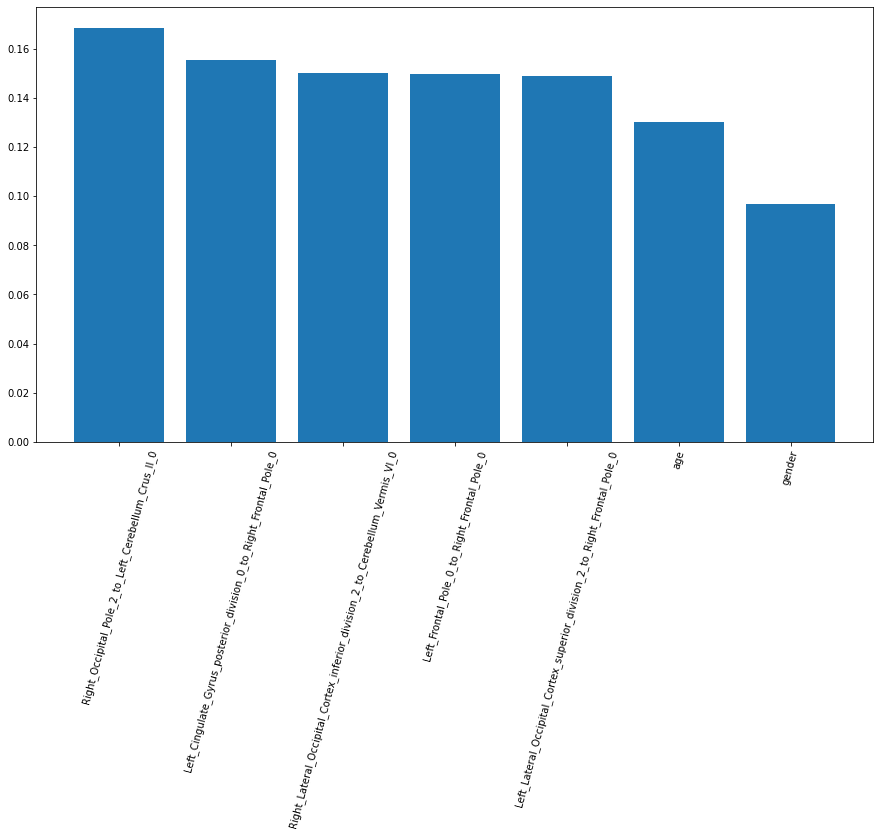

In [17]:
m, cols = train_score(.00001, RandomForestClassifier())

feature_importances = m.feature_importances_
cols = cols.values

feature_importances

order = (-feature_importances).argsort()

plt.figure(figsize=(15,8))
plt.bar(cols[order], feature_importances[order])
plt.xticks(rotation=75);

In [23]:
X_train, X_test, y_train, y_test = subset_train_test(.005, oversample=True)

355 features remaining


0.7492025518341308


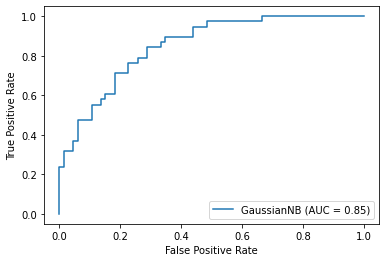

In [24]:
model = GaussianNB().fit(X_train, y_train)
print(roc_auc_score(y_test, model.predict(X_test)))
plot_roc_curve(model, X_test, y_test);